# Vision Transformers from scratch

- [ViT Blogpost by Francesco Zuppichini](https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632)
- [D2L Tutorial ](https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html)
- [Brian Pulfer Medium Blogpost](https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c)
- [Lucidrains implementation Github ](https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py)

## Setup

In [1]:
!pip install einops

   ---------------------------------------- 0.0/44.6 kB ? eta -:--:--
   --------------------------- ------------ 30.7/44.6 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 44.6/44.6 kB 731.0 kB/s eta 0:00:00


DEPRECATION: pytorch-lightning 1.6.0 has a non-standard dependency specifier torch>=1.8.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


## Image Patching



Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: ./


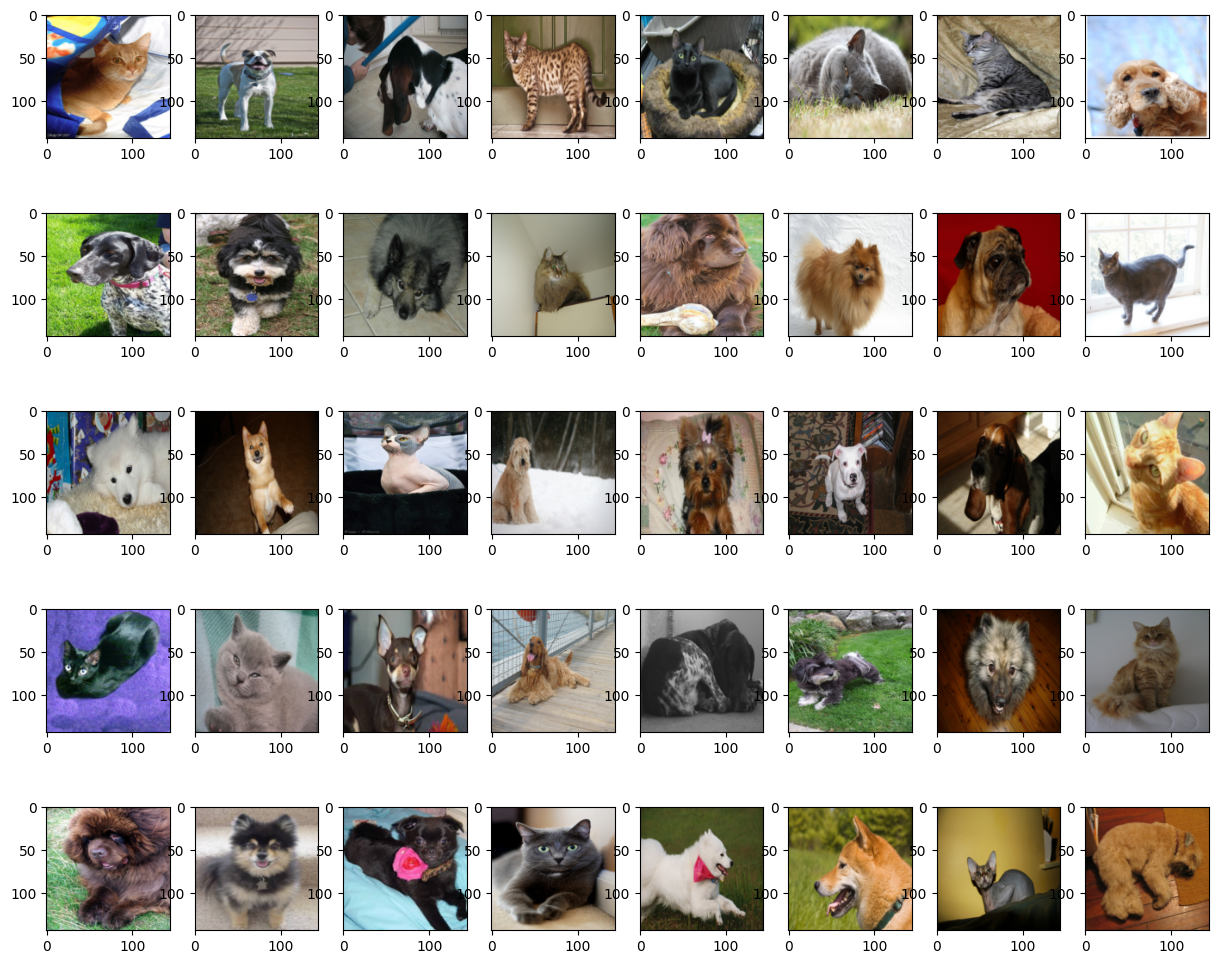

In [2]:
import torch
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

to_tensor = [Resize((144, 144)), ToTensor()]

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
        return image, target

def show_images(images, num_samples=40, cols=8):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    idx = int(len(dataset) / num_samples)
    print(images)
    for i, img in enumerate(images):
        if i % idx == 0:        
            plt.subplot(int(num_samples/cols) + 1, cols, int(i/idx) + 1)
            plt.imshow(to_pil_image(img[0]))

# 200 images for each pet
dataset = OxfordIIITPet(root="./", download=False, transforms=Compose(to_tensor))
show_images(dataset)

### Patch Images

- The following is mainly from the above implementations (not my code)

In [11]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 3, patch_size = 8, emb_size = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x

# Run a quick test
sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
print("Initial shape: ", sample_datapoint.shape)
embedding = PatchEmbedding()(sample_datapoint)
print("Patches shape: ", embedding.shape)

Initial shape:  torch.Size([1, 3, 144, 144])
Patches shape:  torch.Size([1, 324, 128])


## Model

Let's first implement all of the transformer building blocks. These blocks are inspired by the implementations linked above. I've left out some dropouts and normalizations at some places.

In [12]:
from einops import rearrange

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output

In [13]:
Attention(dim=128, n_heads=4, dropout=0.)(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [14]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [15]:
norm = PreNorm(128, Attention(dim=128, n_heads=4, dropout=0.))
norm(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [16]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
ff = FeedForward(dim=128, hidden_dim=256)
ff(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [17]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [18]:
residual_att = ResidualAdd(Attention(dim=128, n_heads=4, dropout=0.))
residual_att(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

- Not all parameters are like in the original implementation
- Some Dropouts & Norms are missing

In [19]:
from einops import repeat

class ViT(nn.Module):
    def __init__(self, ch=3, img_size=144, patch_size=4, emb_dim=32,
                n_layers=6, out_dim=37, dropout=0.1, heads=2):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)
        # Learnable params
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            transformer_block = nn.Sequential(
                ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))))
            self.layers.append(transformer_block)

        # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))


    def forward(self, img):
        # Get patch embedding vectors
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        # Add cls token to inputs
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        # Transformer layers
        for i in range(self.n_layers):
            x = self.layers[i](x)

        # Output based on classification token
        return self.head(x[:, 0, :])


model = ViT()
print(model)
model(torch.ones((1, 3, 144, 144)))


ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (q): Linear(in_features=32, out_features=32, bias=True)
            (k): Linear(in_features=32, out_features=32, bias=True)
            (v): Linear(in_features=32, out_features=32, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (0): Linear(in_features=32, out_featu

tensor([[ 0.4054, -0.3958,  0.2971,  0.2495, -0.2180, -0.3680, -0.3003, -0.1341,
         -0.0568,  0.1245,  1.0713,  0.3277,  0.3428,  0.2308,  0.0223, -0.3891,
          0.1904,  0.8012,  0.4040, -0.7837,  0.0687, -0.5511,  0.1035,  0.3657,
          0.1209, -0.4621,  0.2375, -0.2274, -0.0955, -0.0651, -0.9265, -0.8308,
          0.0911, -0.6465, -0.2715, -0.2739, -0.0921]],
       grad_fn=<AddmmBackward0>)

## Training

In [29]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])

train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

In [30]:
import torch.optim as optim
import numpy as np


device = "cuda"
model = ViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

best_loss = float('inf')  # Initialize the best loss to infinity

for epoch in range(30):  # Adjust the number of epochs as needed
    epoch_losses = []
    model.train()
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    
    train_loss = np.mean(epoch_losses)
    print(f">>> Epoch {epoch} train loss: ", train_loss)
    
    epoch_losses = []
    model.eval()
    for step, (inputs, labels) in enumerate(test_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        epoch_losses.append(loss.item())
    
    test_loss = np.mean(epoch_losses)
    print(f">>> Epoch {epoch} test loss: ", test_loss)
    
    # Save the model if the test loss is lower than the current best loss
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(">>> Best model saved with test loss:", test_loss)

In [16]:
# torch.save(model.state_dict(), 'vit_model.pth')

In [22]:
import torch
from torch import nn

# Assuming you have defined your model class `ViT` in a separate module

# Define your model instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ViT().to(device)

# Load the saved model state dictionary
model.load_state_dict(torch.load('./best_model.pth'))

# It's important to put the model in evaluation mode after loading the weights
model.eval()


ViT(
  (patch_embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): Linear(in_features=48, out_features=32, bias=True)
    )
  )
  (layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (att): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (q): Linear(in_features=32, out_features=32, bias=True)
            (k): Linear(in_features=32, out_features=32, bias=True)
            (v): Linear(in_features=32, out_features=32, bias=True)
          )
        )
      )
      (1): ResidualAdd(
        (fn): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (0): Linear(in_features=32, out_featu

In [33]:
inputs, labels = next(iter(test_dataloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = model(inputs)
print((outputs))
print("Predicted classes", outputs.argmax(-1))
print("Actual classes", labels)

tensor([[ 0.9980,  0.1810, -0.0478,  ..., -0.3833, -1.5268,  0.6242],
        [ 0.9267, -0.0391, -0.0735,  ..., -0.1587, -1.3624,  0.6144],
        [ 0.6063,  0.1335,  0.0097,  ..., -0.2459, -1.4483,  0.6494],
        ...,
        [ 0.8812, -0.1813, -0.1804,  ..., -0.2725, -1.2037,  0.6437],
        [ 0.8001,  0.2008, -0.1521,  ..., -0.3788, -1.2163,  0.5739],
        [ 0.7128,  0.0949, -0.0513,  ..., -0.1973, -1.3653,  0.4622]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Predicted classes tensor([ 9, 13,  4, 13, 33,  4,  4, 33,  6,  4, 13, 13, 13, 13, 13, 13,  4, 13,
         6,  4,  4, 13, 13, 13, 13,  4,  9, 13,  9, 13,  4, 13],
       device='cuda:0')
Actual classes tensor([ 0, 20, 10, 20, 34, 22, 36, 11, 11, 36, 16, 13, 11, 28, 20,  6, 16, 18,
         9, 12, 12, 31,  8, 33,  3,  2, 36, 29, 16, 30,  7,  0],
       device='cuda:0')


In [34]:

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, ToPILImage
import matplotlib.pyplot as plt

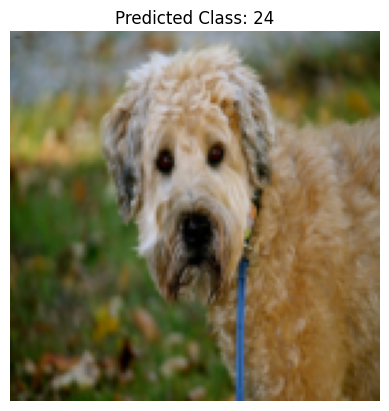

In [146]:
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)
# Get a batch of images and labels from the test dataset
data_iter = iter(test_dataloader)
images, labels = next(data_iter)

# Choose one image from the batch for inference
image = images[0].unsqueeze(0)  # Select the first image and add batch dimension

# Perform inference
with torch.no_grad():
    output = model(image.to(device))

# Convert the output probabilities to predicted class
predicted_class = torch.argmax(output, dim=1).item()

# Convert the torch tensor to a PIL Image
to_pil = ToPILImage()
image_pil = to_pil(image.squeeze(0))

# Display the image and predicted class
plt.imshow(image_pil)  # Display the PIL Image
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()